
# Kaggle - Titanic - Survival prediction
## [1. Reading train and test data](#Reading_data)
## [2. Exploration of the data](#Data_exploration)
## [3. Feature engineering (I) - Filling the NaNs](#Feature_engineering_1)
## [4. Prediction models (I)](#Prediction_models_1)
## [5. Feature engineering (II)](#Feature_engineering_2)
> ### [5.1 Playing with: 'Name'](#FE2_name)
> ### [5.2 Playing with: 'Age'](#FE2_Age)
> ### [5.3 Playing with: 'Embarked'](#FE2_embarked)
> ### [5.4 Playing with: 'Fare'](#FE2_fare)
> ### [5.5 Playing with: 'Ticket'](#FE2_ticket)
> ### [5.6 Playing with: 'Sibsp' and 'Parch'](#FE2_sibsp)

## [6. Prediction models (II)](#Prediction_models_2)

## [7. Feature selection](#Feature_selection)

## [8. Model tuning](#Model_tuning)

## [Save predictions to CSV](#Save_predictions)

<a id="Reading_data"></a> 
# 1. Reading train and test data

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() # Plot style


import IPython
from IPython.display import display
IPython.core.pylabtools.figsize(12, 4)

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from __future__ import division

In [2]:
# Open CSV file for train data and test data
df = []
df.append(pd.read_csv('data/train.csv'))
df.append(pd.read_csv('data/test.csv'))

# Create two different pointers to the train and the test data
df_train = df[0]
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test = df[1]
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
#combined = df[0].append(df[1])

In [ ]:
#print df_train.shape
#print combined.shape

<a id="Data_exploration"></a>
# 2. Exploration of the data

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

In [ ]:
df_train.describe(include=['O'])

In [ ]:
print 'Analysis of null in training dataset'
print '-----------------------------------'
print 'Passenger_id nulls: ' + str(df_train['PassengerId'].isnull().sum())
print 'Pclass nulls: ' + str(df_train['Pclass'].isnull().sum())
print 'Age nulls: ' + str(df_train['Age'].isnull().sum())
print 'SibSp nulls: ' + str(df_train['SibSp'].isnull().sum())
print 'Parch nulls: ' + str(df_train['Parch'].isnull().sum())
print 'Ticket nulls: ' + str(df_train['Ticket'].isnull().sum())
print 'Fare nulls: ' + str(df_train['Fare'].isnull().sum())
print 'Cabin nulls: ' + str(df_train['Cabin'].isnull().sum())
print 'Embarked nulls: ' + str(df_train['Embarked'].isnull().sum())
print '-----------------------------------'
nan_rows = df_train[df_train['Age'].isnull()]
nan_rows.loc[:,:].head()

# Most frequent value per column
print 'Mean/Median/Mode in training dataset per column'
print '-----------------------------------'
print 'Embarked:'
print df_train['Embarked'].value_counts()

print "Fare: Mean = %f , Median = %f , Mode = %f" % (df_train['Fare'].mean(),df_train['Fare'].median(),df_train['Fare'].mode())
#print "Fare: Mean = %f , Median = %f , Mode = %f" % (df_train['Ticket'].mean(),df_train['Ticket'].median(),df_train['Ticket'].mode())
print 'Ticket:'
print df_train['Ticket'].value_counts().head()
print "Age: Mean = %f , Median = %f , Mode = %f" % (df_train['Age'].mean(),df_train['Age'].median(),df_train['Age'].mode())

#### Observations

* Min(Fare) is 0. This could mean that there are babies (for example) free of charge, or actually errors.
* We need to check the distribution of Fare prices, and decide whether making buckets or not.
* There are 2 nulls in 'Embarked'. Replace NaN by 'S', by far the most repeated value.
* Cabin nulls may mean people without a cabin, hence, there were less cabins than people.
* Ticket is alphanumeric
* We have five categorical variables: Sex, Embarked, Class, and Cabin

## 2.1 Ratio of survival in training data

In [ ]:
num_passengers_train = df_train.shape[0]
print 'Number of passengers: ' + str(num_passengers_train)

#num_passengers_survived_train = df_train.groupby('Survived').size()[1]
num_passengers_survived_train = df_train[df_train['Survived']==1].shape[0]
print 'Number of survivors: ' + str(num_passengers_survived_train)

ratio_survival = (num_passengers_survived_train/num_passengers_train)
print 'Survival ratio in training data = ' + str(round(ratio_survival*100,2)) + "%"

## 2.2 Men vs women survival ratio

In [ ]:
# Break by men and women
women_train = df_train[df_train['Sex']=='female']
men_train = df_train[df_train['Sex']=='male']

num_women_train = women_train.shape[0]
num_men_train = men_train.shape[0]
print 'Women on board: ' + str(num_women_train)
print 'Men on board: ' + str(num_men_train)

num_women_survived_train = women_train[women_train['Survived']==1].shape[0]
num_men_survived_train = men_train[men_train['Survived']==1].shape[0]


ratio_survival_women = (num_women_survived_train/num_women_train)
ratio_survival_men = (num_men_survived_train/num_men_train)

print 'Survival ratio for women in training data = ' + str(round(ratio_survival_women*100,2)) + "%"
print 'Survival ratio for men in training data = ' + str(round(ratio_survival_men*100,2)) + "%"

## 2.3 Data Visualisation
* Constrast different subsets of variables to hint correlations

### 2.3.1 Survived vs Pclass and Sex

In [ ]:
# First row
# Survivors and classes
fig, axs = plt.subplots(ncols=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
fig_survived = sns.countplot('Survived', data=df_train, ax=axs[0])
fig_pclass = sns.countplot('Pclass', data=df_train, ax=axs[1])
fig_survived_per_class = sns.pointplot('Pclass', 'Survived', data=df_train, ax=axs[2])

fig_survived_per_class.set(ylim=(0,1))
fig_survived.set_title('Number of survivors')
fig_pclass.set_title('People per class') 
fig_survived_per_class.set_title('% survival per class')

# Second row
# Proportion of survivors per class and sex
fig, axs = plt.subplots(ncols=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
fig_sex = sns.countplot('Sex', data=df_train, ax=axs[0])
fig_survived_by_sex = sns.pointplot('Sex', 'Survived', data=df_train, ax=axs[1])
fig_survived_by_sex_class = sns.pointplot('Pclass', 'Survived', data=df_train, hue='Sex', ax=axs[2])

fig_sex.set_title('People per sex')
fig_survived_by_sex.set_title('% survival per sex')
fig_survived_by_sex.set(ylim=(0, 1.1))
fig_survived_by_sex_class.set_title('% survival per sex & class')
fig_survived_by_sex_class.set(ylim=(0, 1.1))

#### Observations
* The lower the class (3 is worst class than 1), the less the ratio of survival
* Females have an incredible ratio of survival compare to male
* "Women and children first" seems to be true. Check later the age to verify
* Both Sex and Class seems very important for the survival ratio

#### Actions
* Sex and Class need to be included in the model
* Check the real impact of these variables in the models


### 2.3.2 Survived vs embarkation point, class and sex

In [ ]:
# Third row
# Proportion of survivors per embarked. Class per embark point
fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
fig_embarked = sns.countplot('Embarked', data=df_train, ax=axs[0])
fig_survived_by_embarked = sns.pointplot('Embarked', 'Survived', data=df_train, ax=axs[1])

fig_embarked.set_title('People per port')
fig_survived_by_embarked.set_title('% survival per port of embarkation')

# Fourth row
grid = sns.FacetGrid(df_train, col='Embarked', size=3.5, aspect=1)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

#### Observations
* The embarkation port seems to influence, specially in port C 
* Note that 'Male' survival is almost 100% for those who embarked from C, while female is signicantly lower!
* Very low rate of survivals from port Q
* Question: embarkation point could determine the cabin, and the location of the cabin in the Titanic could have been essential, depending on the point of impact with the iceberg

#### Actions
* 

### 2.3.3 Survived vs Age

In [ ]:
# Distribution of survived and dead by age
g = sns.FacetGrid(df_train, col='Survived', size=4, aspect=1)
g.map(plt.hist, 'Age', bins=20)

In [ ]:
# TODO: 
#fig = sns.FacetGrid(df_train, hue='Pclass', size=3, aspect=3)
#fig.map(sns.kdeplot, 'Fare', shade=True, legend=True)
#fig.set(xlim=(0, 80));
#fig.set(ylim=(0, 0.1));
#fig.add_legend()

# Distribution of age by class
fig = sns.FacetGrid(df_train, hue='Pclass', size=3, aspect=3)
fig.map(sns.kdeplot, 'Age', shade=True)
fig.set(xlim=(0, 80));
fig.set(ylim=(0, 0.1));
fig.add_legend()

# Median of Age per class
fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
fig_median_age_class = sns.barplot(data=df_train, x='Pclass', y='Age', estimator=np.median, ax=axs[0])
fig_mean_age_class = sns.barplot(data=df_train, x='Pclass', y='Age', estimator=np.mean, ax=axs[1])

fig_median_age_class.set_title('Median of Age per class')
fig_mean_age_class.set_title('Mean of Age per class')

print 'Median of Age for all classes: ' + str(df_train['Age'].median()) + ' years'
print 'Median of Age for class 1: ' + str(df_train[df_train['Pclass']==1]['Age'].median()) + ' years'
print 'Median of Age for class 2: ' + str(df_train[df_train['Pclass']==2]['Age'].median()) + ' years'
print 'Median of Age for class 3: ' + str(df_train[df_train['Pclass']==3]['Age'].median()) + ' years'

df_train[(df_train['Pclass']==3) & (df_train['Embarked']=='S')]
g = sns.FacetGrid(df_train, col='Pclass', size=4, aspect=1)
g.map(plt.hist, 'Age', bins = 20)

#g = sns.FacetGrid(df_train, col='Embarked', size=4, aspect=1)
#g.map(plt.hist, 'Age', bins = 20)

# Age by class and embarkation point
g = sns.FacetGrid(df_train, row='Embarked', col='Pclass', size=2, aspect=2, margin_titles=True)
g.map(plt.hist, 'Age', bins = 20)


In [ ]:
# How many were not adults?
print 'How many kids in the titanic (train dataset) (<16): ' + str(len(df_train[df_train['Age']<16]))

#### Observations
* There are a few children (<16). This could affect the survival ratio
* Create buckets/bins for Age could be benefitial
* Median/mean of age differs depending on the class. It makes senses, the older people would be wealthier
#### Actions
* Create a new variable 'Person' to distinguish between Woman, Man, and Child
* Try creating a new variable 'Age_range' with 5-6 intervals
* Fill NaN values in Age by taking the median per class (Consider embarkation point as well?)

### 2.3.4 Cabin vs Survived
* Understanding of Cabin codes, and how this could have affected the survival ratio (Titanic's sink was at night)

### 2.3.5 Survived vs Fare

In [ ]:
df_train.describe()
print 'Fare nulls: ' + str(df_train['Fare'].isnull().sum())

In [ ]:
# Distribution of Fare
sns.distplot(df_train['Fare'].dropna(), kde=True, rug=False)
plt.suptitle('Distribution of Fares')
#sns.distplot(df_train['Pclass'=='1'], kde=True, rug=False)

fig, ax = plt.subplots()
fig.suptitle('Distribution of Fares by class')
sns.distplot(df_train[df_train['Pclass']==3]['Fare'], kde=True, rug=False, ax=ax, label="Class 3")
sns.distplot(df_train[df_train['Pclass']==2]['Fare'], kde=True, rug=False, ax=ax, label="Class 2")
sns.distplot(df_train[df_train['Pclass']==1]['Fare'], kde=True, rug=False, ax=ax, label="Class 1")
plt.legend()

axes = plt.gca()
axes.set_ylim([0,0.10])
g = sns.FacetGrid(df_train, col='Pclass', size=4, aspect=1)
g.map(plt.hist, 'Fare', bins = 20)


#g = sns.FacetGrid(df_train, col='Survived', size=4, aspect=1)
#g.map(plt.hist, 'Fare', bins=20)

figure = plt.figure(figsize=(15,8))
plt.hist([df_train[df_train['Survived']==1]['Fare'],df_train[df_train['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 20,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

#### Observations
* Most of the people pay less than 40 for the ticket
* The more someone paid, the better survival ratio. Those who paid more than 100, almost guaranteed their survival
* Fare is very skewed.
#### Actions
* Create intervals for 'Fare'

<a id="Feature_engineering_1"></a> 
# 3. Feature engineering (I) - Only basic stuff to be able to run our first model
* Check if there are NaN values in certain columns, such as Embarked, and replace them by other values
* Data imputation is done in both train and test datasets, but only taking information from the train dataset. This way we avoid to include information from the test dataset into the train one. We may get higher accuracy by also exploring the test dataset, but this is not a good practice
* We will create new features for data imputation, so we can always go back and apply different transformations

**Embarked**: Replace NaN in embarked by 'S', by far the most repeated value.

In [4]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')
print 'Embarked nulls in train: ' + str(df_train['Embarked'].isnull().sum())

df_test['Embarked'] = df_test['Embarked'].fillna('S')
print 'Embarked nulls in test: ' + str(df_test['Embarked'].isnull().sum())

Embarked nulls in train: 0
Embarked nulls in test: 0


**Age**: Replace NaN by median depending on the class and sex

In [5]:
# Calculate the median per class
df_train['AgeFill'] = df_train['Age']
df_test['AgeFill'] = df_test['Age']

age_median_table = df_train.groupby(['Sex','Pclass'])['Age'].median()
print age_median_table

def fill_age_sex_class(x,base_table):
    age = base_table.loc[x['Sex'], x['Pclass']]                 
    return age

df_train['AgeFill'] = df_train.apply(lambda x: fill_age_sex_class(x,age_median_table) if np.isnan(x['AgeFill']) else x['AgeFill'], axis=1)
df_test['AgeFill'] = df_test.apply(lambda x: fill_age_sex_class(x,age_median_table) if np.isnan(x['AgeFill']) else x['AgeFill'], axis=1)

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64


**Fare**: Replace NaN by mean depending on the sex, class and embarkation point

In [6]:
df_train['FareFill'] = df_train['Fare']
df_test['FareFill'] = df_test['Fare']

fare_median_table = df_train.groupby(['Sex', 'Embarked','Pclass'])['Fare'].median()
print fare_median_table

def fill_fare_sex_embarked_class(x,base_table):
    fare = base_table.loc[x['Sex'], x['Embarked'], x['Pclass']]           
    return fare

#df_train['FareFill'] = df_train.apply(lambda x: fill_fare_sex_embarked_class(x,fare_median_table) if np.isnan(x['FareFill']) else x['FareFill'], axis=1)
df_test['FareFill'] = df_test.apply(lambda x: fill_fare_sex_embarked_class(x,fare_median_table) if np.isnan(x['FareFill']) else x['FareFill'], axis=1)

Sex     Embarked  Pclass
female  C         1         83.1583
                  2         24.0000
                  3         14.4583
        Q         1         90.0000
                  2         12.3500
                  3          7.7500
        S         1         79.8250
                  2         23.0000
                  3         14.4500
male    C         1         61.6792
                  2         25.8604
                  3          7.2292
        Q         1         90.0000
                  2         12.3500
                  3          7.7500
        S         1         35.0000
                  2         13.0000
                  3          8.0500
Name: Fare, dtype: float64


<a id="Prediction_models_1"></a>
# 4. Prediction models (I) - With no further optimisations

In [ ]:
# Replace categorical variables (Sex, Embarked, Pclass) by dummy variables
dummy_sex = pd.get_dummies(df_train['Sex'], prefix='Sex')
dummy_embarked = pd.get_dummies(df_train['Embarked'], prefix='Embarked')
dummy_pclass = pd.get_dummies(df_train['Pclass'], prefix='Pclass')

# Create a clean data frame for the regression
cols_to_keep = ['AgeFill', 'SibSp', 'Parch', 'FareFill']
X_train = df_train[cols_to_keep].join(dummy_sex).join(dummy_embarked).join(dummy_pclass)
X_train

Y_train = df_train['Survived']

# Prepare test dataset
# Replace categorical variables (Sex, Embarked, Pclass) by dummy variables
dummy_sex = pd.get_dummies(df_test['Sex'], prefix='Sex')
dummy_embarked = pd.get_dummies(df_test['Embarked'], prefix='Embarked')
dummy_pclass = pd.get_dummies(df_test['Pclass'], prefix='Pclass')
X_test = df_test[cols_to_keep].join(dummy_sex).join(dummy_embarked).join(dummy_pclass)
#X_test

In [7]:
'''
Score a particular model
'''
from sklearn.cross_validation import cross_val_score
def compute_model_score(model, X_train, Y_train, X_test):
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    score = model.score(X_train,Y_train)
    return score, Y_pred
'''
Score a particular model using k-fold cross validation
'''
def compute_model_score_cv(model, X_train, Y_train, X_test):
    fit = model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    x_val = cross_val_score(fit, X_train, Y_train, cv =5, scoring='accuracy')
    return np.mean(x_val), Y_pred

/home/seralde/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
# Build a table with scores for different models
model_list = [{'function': LogisticRegression(), 'name': 'LR'},
              {'function': SVC(), 'name': 'SVC'},
              {'function': KNeighborsClassifier(n_neighbors = 3), 'name': 'KN-3'},
              {'function': DecisionTreeClassifier(), 'name': 'DT'},
              {'function': GaussianNB(), 'name': 'GNB'},
              {'function': Perceptron(), 'name': 'Perceptron'},
              {'function': SGDClassifier(), 'name': 'SGD'},
              {'function': RandomForestClassifier(n_estimators=100), 'name': 'Random Forest'},
              {'function': XGBClassifier(), 'name': 'XGBoost'}
             ]

In [ ]:
model_results = []

for model in model_list:
    score, Y_pred = compute_model_score(model['function'], X_train, Y_train, X_test)
    score_cv, Y_pred = compute_model_score_cv(model['function'], X_train, Y_train, X_test)
    model_results.append([model['name'], score, score_cv, Y_pred])

In [ ]:
# Show results obtained sorted by score
df_model_results = pd.DataFrame (model_results, columns=('Model', 'Score', 'Score-CV', 'Prediction'))  
df_model_results.sort_values(by='Score-CV', ascending=False)

### Analyze results
* TODO: See which variables are more important. This will help us to optimise the model

#### Write result in a csv

In [ ]:
# Choose model and save its prediction
#print df_model_results.loc[7]
#Y_pred = df_model_results.loc[7]['Prediction']

# Take model with best score
Y_pred = df_model_results.sort_values(by='Score-CV', ascending=False).iloc[0]['Prediction']
print Y_pred

submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred   
})  
 
submission.to_csv('submission.csv', index=False)

<a id="Feature_engineering_2"></a>
# 5. Feature Engineering (II)
* Apply domain knowledge to see if we can improve the initial results

<a id="FE2_name"></a>
## 5.1. Playing with 'Name'
* The variable 'name' contains not only the firstname and surname of the passenger, but also the title. We may extract something useful if we process this feature. Title may be related to social status, which might have an effect on the survival opportunities in the Titanic.
* All names in the dataset have the format 'Surname, Title. Name (aka name)

In [9]:
# Parse the feature to extract all titles
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'unknown'

#list_titles = sorted(set([x for x in train.Name.map(lambda x: get_title(x))]))
list_title = df_train['Name'].apply(lambda x: get_title(x))
print list_title.value_counts()

#list_title = df_test['Name'].apply(lambda x: get_title(x))
#print list_title.value_counts()

#df_train[df_train['Name'].str.contains('Master')]

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Name, dtype: int64


After having a look on the title, we can notice that there are a few titles that can be merged:
* There are not enough occurrences of certain titles. It would be better to create a category for those that seem to belong to cabin crew members
* 'Mme' is 'Madame', the French equivalent to Ms. We will transform this title to Miss
* 'Mlle' is 'Mademoiselle', the French equivalent to Miss.
* 'Col'->Colonel. 'Capt'->Captain. 'Major'
* 'Lady' is a noble title, or the wife of a Lord, Baron or Sir.
* 'Jonkheer' is Dutch honorific of nobility.
* 'Master' is used for male young and unmarried children.
* 'Don' is a Spanish noble title. We will merge all noble titles to one value: 'noble'.
* 'Rev' is Reverend. Merge it with another title? Think about Dr as well. They could belong to the cabin crew
* We will assume that 'Dr' only refers to medical doctors, who could be part of the cabin crew.

There might be more honorific titles that are not present in the train data, but in the test data or the score data. It is not possible to take into account all possible titles. 

In [10]:
# Create a new feature with the title of each person

# Map of titles
Title_Dictionary = {
    "Mr" :        "Mr",
    "Miss" :      "Miss",
    "Mlle":       "Miss",
    "Mme":        "Miss",
    "Ms":         "Miss",
    "Mrs" :       "Mrs",
    "Master" :    "Master",
    "Dr":         "Crew",
    "Rev":        "Crew",
    "Capt":       "Crew",
    "Col":        "Crew",
    "Major":      "Crew",
    "Jonkheer":   "Noble",
    "Don":        "Noble",
    "Dona":       "Noble",
    "Sir" :       "Noble",
    "Lady" :      "Noble",
    "the Countess":"Noble"
}

df_train['Title'] = df_train['Name'].apply(lambda x: get_title(x))
df_train['Title'] = df_train['Title'].map(Title_Dictionary)

df_test['Title'] = df_test['Name'].apply(lambda x: get_title(x))
df_test['Title'] = df_test['Title'].map(Title_Dictionary)

<a id="FE2_age"></a>
## 5.2. Playing with: 'Age'
* TODO: Play with the fact that 'Woman and Child first!'
* TODO: Possibly create another variables for child (<16) 
* Estimate the age using the missing titles as well

In [11]:
# Calculate the median of age per Sex, Class and Title
df_train['AgeFill'] = df_train['Age']
df_test['AgeFill'] = df_test['Age']

age_median_table = df_train.groupby(['Sex','Pclass','Title'])['Age'].median()
print age_median_table

def fill_age_sex_class_title(x,base_table):
    age = base_table.loc[x['Sex'], x['Pclass'], x['Title']]                 
    return age

df_train['AgeFill'] = df_train.apply(lambda x: fill_age_sex_class_title(x,age_median_table) if np.isnan(x['AgeFill']) else x['AgeFill'], axis=1)
df_test['AgeFill'] = df_test.apply(lambda x: fill_age_sex_class_title(x,age_median_table) if np.isnan(x['AgeFill']) else x['AgeFill'], axis=1)

Sex     Pclass  Title 
female  1       Crew      49.0
                Miss      29.5
                Mrs       41.5
                Noble     40.5
        2       Miss      24.0
                Mrs       32.0
        3       Miss      18.0
                Mrs       31.0
male    1       Crew      51.0
                Master     4.0
                Mr        40.0
                Noble     40.0
        2       Crew      46.5
                Master     1.0
                Mr        31.0
        3       Master     4.0
                Mr        26.0
Name: Age, dtype: float64


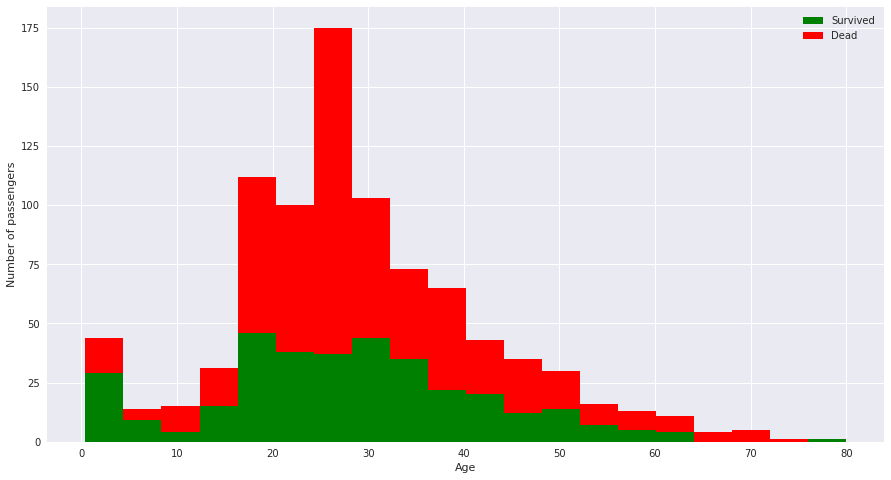

In [46]:
# Solve NaN in Age before plotting this
figure = plt.figure(figsize=(15,8))
plt.hist([df_train[df_train['Survived']==1]['AgeFill'],df_train[df_train['Survived']==0]['AgeFill']], 
         stacked=True, color = ['g','r'],
         bins = 20,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

In [ ]:
def person(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]

# Create 5 intervals for age
#pd.cut(df_train['Age'], 5)

# Create a new colum    
df_train['Person'] = df_train[['Age','Sex']].apply(person, axis=1)
    
# Survived by Adults and kids (and sex)
#fig_survived_by_age = sns.pointplot('Age', 'Survived', data=df_train)
fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
fig_person = sns.countplot('Person', data=df_train, ax=axs[0])
fig_survived_by_person = sns.pointplot('Person', 'Survived', data=df_train, ax=axs[1])

fig_person.set_title('Distribution by Adults or Kids')
fig_survived_by_person.set_title('% survival of Man, Woman and Child')
fig_survived_by_person.set(ylim=(0, 1.1))

<a id="FE2_embarked"></a>
## 5.3. Playing with: 'Embarked'

<a id="FE2_fare"></a>
## 5.4. Playing with: 'Fare'
* **TODO**: It seems that there are errors in the Fare. Change these values for the median of their class
* As the distribution of the bin is too skewed, we will create intervals (bins).
    * It did not seems that this transformation affected that much

In [13]:
# Checking fare errors or free tickets
# df_train[['Pclass','Age','Fare']][df_train['Fare']<5]

# Create 5 bins to represent the Fare. Create bins using TRAIN dataset
df_train['FareBin'], fare_bins = pd.qcut(df_train['FareFill'], 5, retbins=True)
df_test['FareBin'] = pd.cut(df_test['FareFill'], bins=fare_bins)
print fare_bins

# Since qcut() creates a new variable that identifies a range, we need to factorize (sorted) or create dummies
df_train['FareBinID'] = pd.factorize(df_train['FareBin'], sort=True)[0]
df_test['FareBinID'] = pd.factorize(df_test['FareBin'], sort=True)[0]

[   0.        7.8542   10.5      21.6792   39.6875  512.3292]


<a id="FE2_ticket"></a>
## 5.5. Playing with: 'Ticket'
* Ticket seems a difficult variable to process, but there is no nulls in both train and test dataset, and we should be able to extract something meaningful from it
* Tickets are either a number, or a alphanumeric prefix + number. This prefix could contain extra info, such as location at the Titanic (deck)
* There seems to be a repetition on the ticket number. This may mean people 'travelling together', which could be useful together with FamilyID to cover those cases of extra people travelling with the Family (nannies, servants, etc.) that could have a stronger chance of survival.

In [14]:
print('Ticket nulls in Train=%d; and Test=%d' % (df_train['Ticket'].isnull().sum() , df_test['Ticket'].isnull().sum()))

#df_train['Ticket'].describe(include='all')
#print df_train['Ticket'].value_counts().head(3)

# How many different prefix do we have?
def getTicketPrefix(ticket):   
    prefix = ticket.split()[0].replace('.','').replace('/','')
    if prefix.isdigit():
        return 'U'
    else:
        return prefix
    
def getTicketNumber(ticket):
    ticket_number_pattern = re.compile("([0-9]+$)")
    match = ticket_number_pattern.search(ticket)
    if match:
        return match.group()
    else:
        return 0 # Unknown
    
# Create multiple features with ticket. We can later discard as many as we want
df_train['TicketPrefix'] = df_train['Ticket'].apply(lambda x: getTicketPrefix(x.upper()))
df_train['TicketNumber'] = df_train['Ticket'].apply(lambda x: getTicketNumber(x.upper()))
df_train['TicketFirstDigit'] = df_train['TicketNumber'].apply(lambda x: str(x)[0]).astype(np.int)
df_train['TicketNumDigits'] = df_train['TicketNumber'].apply(lambda x: len(str(x))).astype(np.int)

#display(df_train)
#display(df_train['TicketPrefix'].value_counts())

df_test['TicketPrefix'] = df_test['Ticket'].apply(lambda x: getTicketPrefix(x.upper()))
df_test['TicketNumber'] = df_test['Ticket'].apply(lambda x: getTicketNumber(x.upper()))
df_test['TicketFirstDigit'] = df_test['TicketNumber'].apply(lambda x: str(x)[0]).astype(np.int)
df_test['TicketNumDigits'] = df_test['TicketNumber'].apply(lambda x: len(str(x))).astype(np.int)

# Process ticket creating same categories for train and test. Otherwise, we will be getting different columns
train_categories = df_train['TicketPrefix'].astype('category').cat.categories.tolist()
test_categories = df_test['TicketPrefix'].astype('category').cat.categories.tolist()
ticket_categories = list(set().union(train_categories,test_categories))

print ticket_categories
# Set TicketPrefix feature as categorical, using the previous list
df_train['TicketPrefix'] = df_train['TicketPrefix'].astype('category', categories=ticket_categories)
df_test['TicketPrefix'] = df_test['TicketPrefix'].astype('category', categories=ticket_categories)

Ticket nulls in Train=0; and Test=0
['SCAH', 'WC', 'STONO', 'FCC', 'SOPP', 'FA', 'FC', 'LINE', 'SWPP', 'PP', 'SOP', 'SOTONOQ', 'STONOQ', 'PC', 'PPP', 'A5', 'A4', 'LP', 'SCPARIS', 'A', 'AQ4', 'C', 'AQ3', 'SOTONO2', 'CA', 'SOC', 'AS', 'STONO2', 'U', 'SP', 'SCOW', 'WEP', 'CASOTON', 'SC', 'SCA3', 'SCA4']


<a id="FE2_sibsp"></a>
## 5.6.  Playing with:  'SibSp' and 'Parch'
* SibSp (Number of Siblings/Spouses Aboard) and Parch (Number of Parents/Children Aboard) could be merged into one feature: 'FamilySize'
* Create variable 'Alone' (or without family), as derivate of SibSp and Parch

In [15]:
# Create 'FamilySize' feature
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 

# Create boolean 'Alone' feature
df_train['Alone'] = df_train.apply(lambda x: 1 if (x['FamilySize']==1) 
                                   else 0, axis=1)
df_test['Alone'] = df_test.apply(lambda x: 1 if (x['FamilySize']==1) 
                                   else 0, axis=1)

<a id="Prediction_models_2"></a>
# 6. Prediction models (II) - After more feature engineering

** TODO ** Make graph to see the importance of each variable for a model
* We will scale the variables. Although Random Forest and decision trees in general are not affected by unnormalised variables, other mother may be affected. 
    * This made a large improvement on the accuracy, for certain models, such as SVM
* Ticket dummies do not seem to improve the result

In [94]:
# Create a clean data frame for the regression

# Columns to keep
#cols_to_keep = ['AgeFill', 'SibSp', 'Parch', 'FareFill', 'FamilySize', 'Alone']
cols_to_keep = ['AgeFill', 'SibSp', 'Parch', 'FareFill', 'FamilySize', 'Alone', 'TicketFirstDigit', 'TicketNumDigits']
##cols_to_drop = ['TicketPrefix', 'TicketNumber', 'TicketFirstDigit', 'TicketNumDigits']

# Replace categorical variables by dummy variables
#cols_dummy = ['Sex', 'Embarked', 'Pclass', 'Title']
cols_dummy = ['Sex', 'Embarked', 'Pclass', 'Title', 'TicketPrefix'] # Worse accuracy

# Training set
X_train = df_train[cols_to_keep].join(
    pd.get_dummies(df_train[cols_dummy], prefix=cols_dummy, columns=cols_dummy))

# Target
Y_train = df_train['Survived']

# Test set
X_test = df_test[cols_to_keep].join(
    pd.get_dummies(df_test[cols_dummy], prefix=cols_dummy, columns=cols_dummy))

# Scale features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [95]:
model_results = []
X_train_transformed = X_train_std
X_test_transformed = X_test_std
#X_train_ = X_train
#X_test_ = X_test

for model in model_list:
    score, Y_pred = compute_model_score(model['function'], X_train_transformed, Y_train, X_test_transformed)
    score_cv, Y_pred = compute_model_score_cv(model['function'], X_train_transformed, Y_train, X_test_transformed)
    model_results.append([model['name'], score, score_cv, Y_pred])

In [96]:
# Show results obtained sorted by score
df_model_results = pd.DataFrame (model_results, columns=('Model', 'Score', 'Score-CV', 'Prediction'))  
df_model_results.sort_values(by='Score-CV', ascending=False)

,Model,Score,Score-CV,Prediction
8,XGBoost,0.882155,0.832789,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
7,Random Forest,0.988777,0.820392,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ..."
1,SVC,0.846240,0.819338,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, ..."
0,LR,0.845118,0.814888,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
2,KN-3,0.881033,0.799150,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ..."
3,DT,0.988777,0.792364,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ..."
6,SGD,0.784512,0.723029,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
5,Perceptron,0.799102,0.716274,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
4,GNB,0.419753,0.410745,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."


<a id="Feature_selection"></a>
# 7. Feature Selection
* We may have too many features. We'll try to simplify our models to see if we can get more accuracy

In [97]:
from sklearn.feature_selection import SelectFromModel

model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
fit = model.fit(X_train,Y_train)
score_cv_before, Y_pred = compute_model_score_cv(model, X_train, Y_train, X_test)

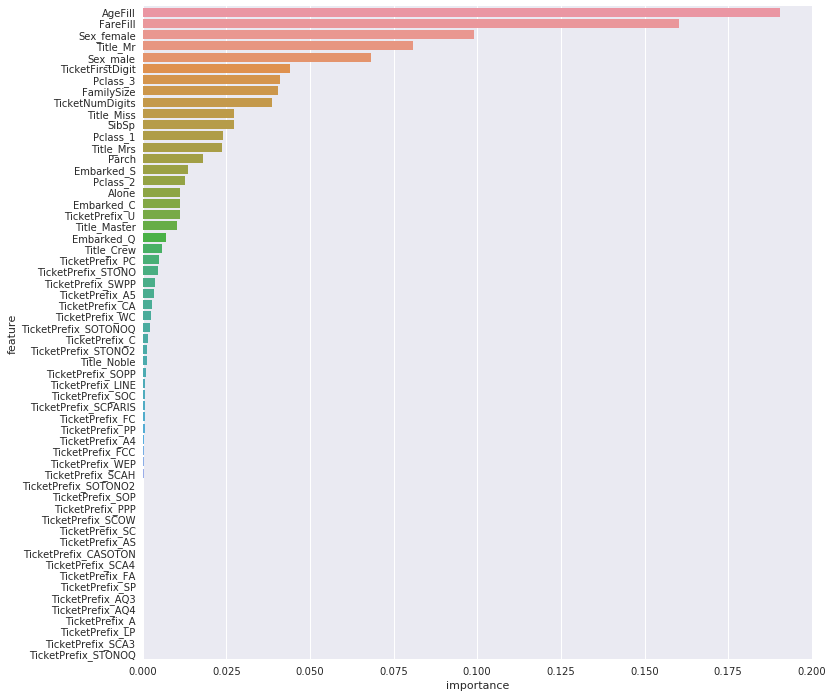

In [98]:
# Get importance for each feature
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = fit.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
#features.set_index('feature', inplace=True)
features = features.reset_index(drop=True)

# Plot feature importances
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(ax=ax, data=features, y='feature', x='importance')

In [99]:
# Select features using sklearn's SelectFromModel()
model_reduced = SelectFromModel(fit, prefit=True)
X_train_reduced = model_reduced.transform(X_train)
print 'X_train reduced from ' + str(X_train.shape) + ' to ' + str(X_train_reduced.shape)

model_reduced = SelectFromModel(fit, prefit=True)
X_test_reduced = model_reduced.transform(X_test)
print 'X_test reduced from ' + str(X_test.shape) + ' to ' + str(X_test_reduced.shape)

X_train reduced from (891, 58) to (891, 14)
X_test reduced from (418, 58) to (418, 14)


In [101]:
# Try Random Forest again with the reduced list of features
model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
score_cv_after, Y_pred = compute_model_score_cv(model, X_train_reduced, Y_train, X_test_reduced)

print 'Score before: ' + str(score_cv_before)
print 'Score after: ' + str(score_cv_after)

Score before: 0.806983896301
Score after: 0.823863433657


<a id="Model_tuning"></a>
# 8. Model tuning
* Let's tune Random Forest (We'll take as reference scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html )

In [105]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train_reduced, Y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 45.68 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.840 (std: 0.021)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 7, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.831 (std: 0.023)
Parameters: {'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 7, 'criterion': 'entropy', 'max_features': 5, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.829 (std: 0.018)
Parameters: {'bootstrap': False, 'min_samples_leaf': 10, 'min_samples_split': 6, 'criterion': 'gini', 'max_features': 6, 'max_depth': None}



In [110]:
best_parameters = random_search.best_params_
best_parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model = RandomForestClassifier(n_estimators=100, **best_parameters)
score_cv, Y_pred = compute_model_score_cv(model, X_train_reduced, Y_train, X_test_reduced)
print score_cv

0.832833437419


Mean validation score: 0.840 (std: 0.021)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 7, 'max_depth': None}

In [ ]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(model, param_grid=param_grid)
start = time()
grid_search.fit(X_train_reduced, Y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

<a id="Save_predictions"></a>
# Save predictions to CSV

In [112]:
# Choose model and save its prediction
#print df_model_results.loc[7]
#Y_pred = df_model_results.loc[7]['Prediction']

# Take model with best score
#Y_pred = df_model_results.sort_values(by='Score-CV', ascending=False).iloc[0]['Prediction']
print Y_pred

submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred   
})  

filename = 'submission_RF_bestParameters.csv'
submission.to_csv(filename, index=False)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]
